# Jobs and Salaries Text Analysis Project
## Econ 1680: MLTA and Econ
#### Name: Lena Kim

It is a known fact that many companies receive thousand and thousands of job applications
a day, and as such rely on algorithms to screen resumes. In fact, a New York Times coverage of the ever-increasing 
reliance on resume algorithms has even led to the identification
of keywords and skills to include in your resume to make it past this resume sifter (Weed
(2021)). As a Post article states, including even one of these key words can mean the differ-
ence between getting hired and being discarded (Abril (2023).

Taking inspiration from this trend, I want to accurately predict the salary levels of a job
based on keywords used in its job description, as well as the resumes that it gets. With
some companies remaining tight-lipped in regards to salary transparency, this text analysis
project may be useful for job seekers who want to know more about compensation before
taking any steps toward subjecting themselves to a cold, algorithmic hiring process.

Research Question: Using keywords and skills in the job description, can we accurately
predict the salary of the job?


# Focus: Preprocessing and Data Cleaning
This notebook focuses on data preprocessing and cleaning. There will be separate notebooks for methods


In [3]:
#for general and EDA:
import requests
from pprint import pprint
import pandas as pd
import time
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import regex as re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#for preprocessing:
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from langdetect import detect
#for regressions:
from transformers import pipeline
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#for neural net:
from keras.models import Sequential
from keras.layers import Dense

In [4]:
indeed_jobs = pd.read_csv('data/indeed_jobs.csv')

In [5]:
#indeed_jobs = indeed_jobs.drop_duplicates() #drop duplicate rows that were scraped 
indeed_jobs = indeed_jobs.drop_duplicates(subset=['description']) #drop duplicate rows that were scraped

indeed_jobs.head()

,company,companyInfo/companyDescription,companyInfo/companyLogo,companyInfo/indeedUrl,companyInfo/rating,companyInfo/reviewCount,companyInfo/url,description,descriptionHTML,externalApplyLink,...,positionName,postedAt,postingDateParsed,rating,reviewsCount,salary,scrapedAt,searchInput/country,searchInput/location,url
0,Maximus,"As a well-respected government contractor, we’...",https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Maximus-1,3.5,7644.0,https://maximus.com,"Every day, Customer Service Representatives (C...","<p>Every day, Customer Service Representatives...",NaN,...,Customer Service Representative (Remote in NY),NaN,2024-03-23T16:48:26.224Z,3.5,7644.0,$19.75 an hour,2024-04-01T16:48:26.227Z,US,New York,https://www.indeed.com/rc/clk?jk=fb57ed7bb664b...
1,AIG,AIG and its member companies form one of the w...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/AIG,3.7,4517.0,http://www.aig.com,Underwriter Technician \n\n This Underwriter r...,Underwriter Technician \n<br>\n<br> This Under...,https://aig.wd1.myworkdayjobs.com/en-US/aig/jo...,...,Underwriting Technician,NaN,2024-03-02T16:48:22.945Z,3.7,4517.0,"$51,000 - $70,000 a year",2024-04-01T16:48:22.950Z,US,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Unitedhealthcare,3.7,2449.0,http://www.uhc.com/,If you are located within the state of New Yor...,<div>\n <p><b>If you are located within the st...,https://careers.unitedhealthgroup.com/job/2015...,...,Associate Claims Representative - Remote in NY,NaN,2024-03-28T16:48:18.656Z,3.7,2449.0,$16.00 - $28.27 an hour,2024-04-01T16:48:19.955Z,US,New York,https://www.indeed.com/rc/clk?jk=4827d1f6ae094...
3,AAA Northeast,AAA Northeast is one of the largest and most i...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Aaa-Northeast,3.4,401.0,http://northeast.aaa.com,Eligible applicants must live within the AAA N...,<div>\n <p>Eligible applicants must live withi...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,"Call Center Representative (remote) - Utica, NY",NaN,2024-03-14T16:48:23.352Z,3.4,401.0,$18.50 - $19.50 an hour,2024-04-01T16:48:23.448Z,US,New York,https://www.indeed.com/rc/clk?jk=f721fe2d368ea...
4,Marram Montauk,NaN,NaN,https://www.indeed.com/cmp/Society-Caf%C3%A9--...,NaN,NaN,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,<p><b>ABOUT OUR COMPANY</b><br>Marram Montauk ...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,Resort General Manager,NaN,2024-03-30T16:48:21.361Z,NaN,NaN,"$150,000 - $170,000 a year",2024-04-01T16:48:22.669Z,US,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...


# Data Cleaning and Prep:
### clean to what we need: 
job title, job descriptions, salary

In [6]:
indeed_jobs = indeed_jobs[['company', 'companyInfo/companyDescription', 'description', 'positionName', 'salary']] #select relevant cols


In [7]:
indeed_jobs.head()


,company,companyInfo/companyDescription,description,positionName,salary
0,Maximus,"As a well-respected government contractor, we’...","Every day, Customer Service Representatives (C...",Customer Service Representative (Remote in NY),$19.75 an hour
1,AIG,AIG and its member companies form one of the w...,Underwriter Technician \n\n This Underwriter r...,Underwriting Technician,"$51,000 - $70,000 a year"
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,If you are located within the state of New Yor...,Associate Claims Representative - Remote in NY,$16.00 - $28.27 an hour
3,AAA Northeast,AAA Northeast is one of the largest and most i...,Eligible applicants must live within the AAA N...,"Call Center Representative (remote) - Utica, NY",$18.50 - $19.50 an hour
4,Marram Montauk,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,Resort General Manager,"$150,000 - $170,000 a year"


In [8]:
indeed_jobs['salary']

0                  $19.75 an hour
1        $51,000 - $70,000 a year
2         $16.00 - $28.27 an hour
3         $18.50 - $19.50 an hour
4      $150,000 - $170,000 a year
                  ...            
694      $60,000 - $70,000 a year
696                   $17 an hour
697    $102,390 - $233,450 a year
698       $33.18 - $38.16 an hour
699                $39.33 an hour
Name: salary, Length: 654, dtype: object

### Convert all salaries to yearly salaries, in floats

In [9]:

def convert_to_yearly(salary):
    if pd.isnull(salary):  #handle NaN values
        return np.nan

    #remove commas and whitespace
    salary = salary.replace(',', '').strip()

    if 'an hour' in salary:
        hourly_rate = float(re.search(r'\d+\.*\d*', salary).group()) #extract hourly rate
        yearly_salary = hourly_rate * 40 * 50  #assume 40 hrs a week and 50 work weeks.
    elif 'a day' in salary:
        daily_rate = float(re.search(r'\d+\.*\d*', salary).group())
        yearly_salary = daily_rate * 5 * 50 #assume 5 days of work, 50 weeks of work
    else:
        annual_rate = re.findall(r'\d+\.*\d*', salary) #extract annual rate
        if len(annual_rate) == 1:
            yearly_salary = float(annual_rate[0]) #return value if there's only one posted salary (not a range)
        else:
            lower_rate = float(annual_rate[0])
            upper_rate = float(annual_rate[1])
            yearly_salary = (lower_rate + upper_rate) / 2 #return avg of min and max bound salary (for a range)
        
    return yearly_salary



In [10]:
#apply the function to the 'salary' column
indeed_jobs['yearly_salary'] = indeed_jobs['salary'].apply(convert_to_yearly)

indeed_jobs.head()

,company,companyInfo/companyDescription,description,positionName,salary,yearly_salary
0,Maximus,"As a well-respected government contractor, we’...","Every day, Customer Service Representatives (C...",Customer Service Representative (Remote in NY),$19.75 an hour,39500.0
1,AIG,AIG and its member companies form one of the w...,Underwriter Technician \n\n This Underwriter r...,Underwriting Technician,"$51,000 - $70,000 a year",60500.0
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,If you are located within the state of New Yor...,Associate Claims Representative - Remote in NY,$16.00 - $28.27 an hour,32000.0
3,AAA Northeast,AAA Northeast is one of the largest and most i...,Eligible applicants must live within the AAA N...,"Call Center Representative (remote) - Utica, NY",$18.50 - $19.50 an hour,37000.0
4,Marram Montauk,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,Resort General Manager,"$150,000 - $170,000 a year",160000.0


In [11]:
indeed_jobs.describe()

,yearly_salary
count,632.000000
mean,69343.348101
std,45391.712132
min,325.000000
25%,40000.000000
50%,57510.000000
75%,85000.000000
max,440000.000000


# Analysis I: Wordclouds of Job Descriptions

In [12]:
indeed_jobs['description'].head()

0    Every day, Customer Service Representatives (C...
1    Underwriter Technician \n\n This Underwriter r...
2    If you are located within the state of New Yor...
3    Eligible applicants must live within the AAA N...
4    ABOUT OUR COMPANYMarram Montauk is located on ...
Name: description, dtype: object

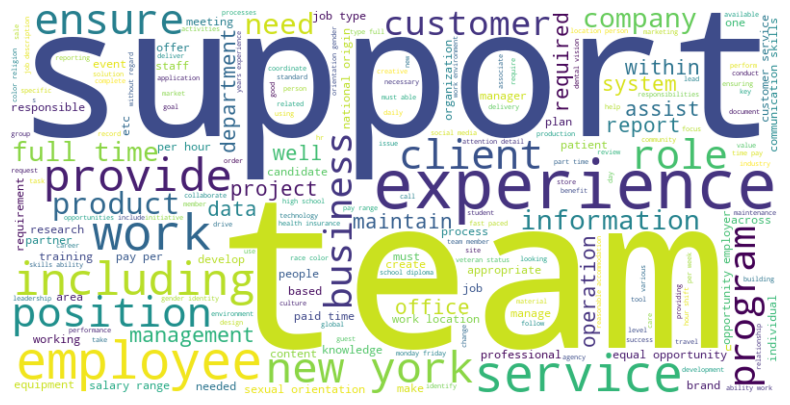

<Figure size 640x480 with 0 Axes>

In [15]:

text = ' '.join(indeed_jobs['description']) #combine all jobs descriptions into one single text for easier word cloud

#Now remove stopwords:
words = word_tokenize(text) 
stop_words = set(stopwords.words('english'))
words = [word.lower() for word in words if word.lower() not in stop_words and word.lower() not in string.punctuation]

text_cleaned = ' '.join(words)

#generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_cleaned) 

#display specifications:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig('wordcloud_general.png')

In [12]:
#The above in ranked text form:
words = text_cleaned.split()
word_counts = Counter(words)
word_counts.most_common(15)



[('work', 2245),
 ('experience', 1896),
 ('’', 1620),
 ('team', 1269),
 ('skills', 1186),
 ('ability', 1092),
 ('job', 1047),
 ('required', 1019),
 ('new', 969),
 ('including', 959),
 ('benefits', 955),
 ('position', 929),
 ('time', 839),
 ('must', 754),
 ('company', 750)]

## Wordclouds based on job type

In [13]:
len(indeed_jobs['positionName'].unique()) #622 unique job types

622

In [14]:
indeed_jobs['positionName'].unique()

array(['Customer Service Representative (Remote in NY)',
       'Underwriting Technician',
       'Associate Claims Representative - Remote in NY',
       'Call Center Representative (remote) - Utica, NY',
       'Resort General Manager', 'Paraprofessional',
       'House Cleaner and apartment turnovers and office cleaning',
       'Driver/Operator',
       'Dog Handler & Welfare Advocate | Professional Dog Care',
       'Flight Attendant', 'Talent Assistant', 'Teller',
       'Call Center Agent', 'Deli Associate', 'Construction Flagger',
       'Reimbursement Specialist', 'Rural Carrier Associate',
       'Transportation Security Officer',
       'Registered Nurse (RN) Supervisor', 'Work Coordinator',
       'Assistant Signalman-Signal', 'Brewery Representative',
       'City Administrator', 'AutoCAD Drafter', 'Global Associate, CNCC',
       'Associate – [MT7750181]', 'Commerce Writer, Condé Nast Traveler',
       'ALEXANDER MCQUEEN Public Relations Coordinator',
       'Early Career

In [15]:
#function for generating word cloud
def generate_wordcloud(input_string): 
    #input string will be the job type chosen to analyze - e.g. "data" or "analyst"
    words = word_tokenize(input_string)
    
    #remove stopwords and punctuation:
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if word.lower() not in stop_words and word.lower() not in string.punctuation] 

    #join words back to single string:
    cleaned_text = ' '.join(words)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text) #generate word cloud!

    #display specifications
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

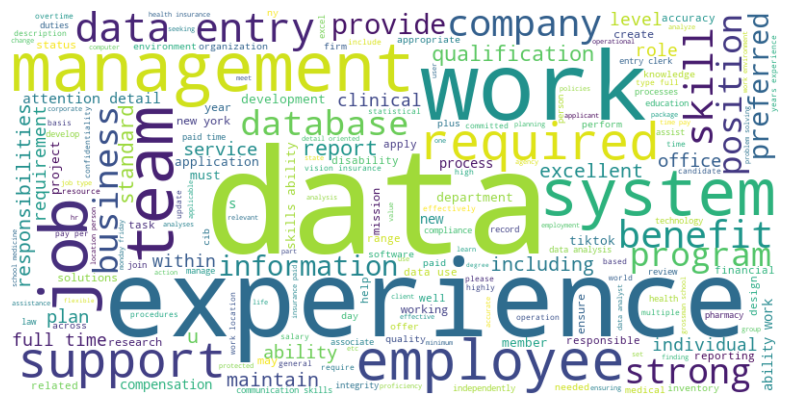

In [16]:
#Data
#create word clouds by select job types:
indeed_data = indeed_jobs[indeed_jobs['positionName'].str.contains('Data')] #filter by jobs types that have to do with data
#indeed_data.head()

#make word cloud:
data_text = ' '.join(indeed_data['description']) #combine all data jobs descriptions into one single text for easier word cloud
generate_wordcloud(data_text)

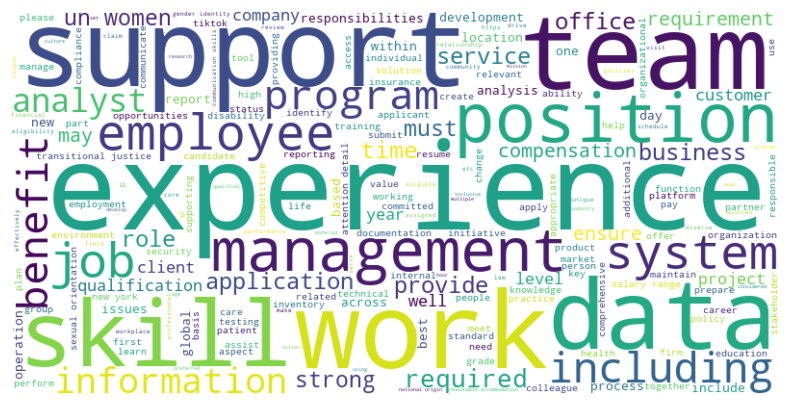

In [17]:
#Analysts:

indeed_analyst = indeed_jobs[indeed_jobs['positionName'].str.contains('Analyst')] #filter by jobs types that have to do with analysis of any kind

analyst_text = ' '.join(indeed_analyst['description'])
generate_wordcloud(analyst_text)


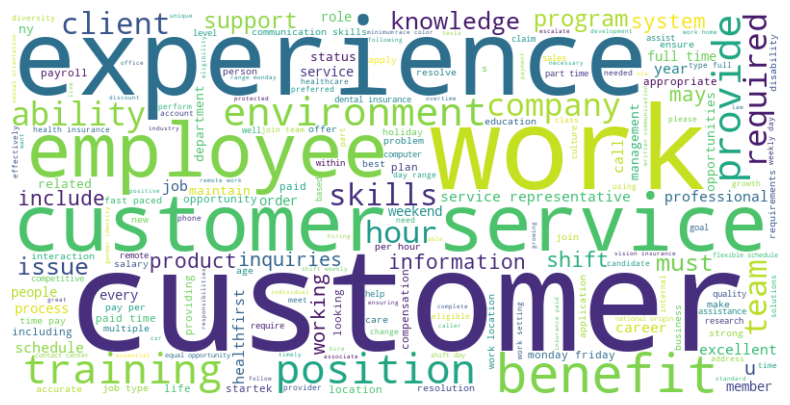

In [18]:
indeed_client_facing = indeed_jobs[indeed_jobs['positionName'].str.contains('Customer')] #i.e. customer service rep

client_text = ' '.join(indeed_client_facing['description'])
generate_wordcloud(client_text)

## Preprocessing: 
Stemming, Removing similarities more than 85, Lemmatization of job descriptions

In [6]:
cleandesc=[] #initializes empty list where cleaned descriptions will be put 
for i in range(len(indeed_jobs)): #iterates over each row
    desc=indeed_jobs['description'][i] #loop variable i is assigned value from dataframe
    desc=desc.replace('\r',' ') #replaces carriage return (i.e. cursor control characters) with space
    desc=desc.replace('\n',' ') #replaces newline characters with space
    desc=desc.replace('. ',' ') #replaces periods followed by a space with just a space
    desc=desc.replace(', ',' ') #replaces commas followed by a space with just a space
    tokens = desc.split(' ') #splits description into list of tokens, where the separator is a space
    desc_hashtags=[] #intializes tweet hashtag list
    desc_token=[] #intializes tweet tokens list
    for t in tokens: #iterates over each word in tokens list
        if "https:" not in t: 
            desc_token.append(t) #checks that the word doesn't contain https: (i.e. url) and then appends the word 
    cleandesc.append(" ".join(desc_token).lower()) #joins the cleaned list of tokens into a string, lowercases everything, and appends 
    #it to cleandesc
indeed_jobs['clean description']= cleandesc #makes a new column called clean tweet that houses clean description list values

#### Below Takes a few min to run. 5-10
similar_level=85 #sets threshold for similarity level. If two tweets are above this, then they're considered duplicates
duplicate_index = [] #sets up a list for indices of duplicate words. 
for original in range(len(indeed_jobs)-1): 
    print((original / len(indeed_jobs) * 100), '%' )#Allows to track progress as code runs by printing out percent of tweets completed
    if original not in duplicate_index:
        for compared in range(original+1, len(indeed_jobs)): #iterates over indices greater than current index, avoiding previously compared indices
            if compared not in duplicate_index: #checks if compared not in duplicate_index
                if fuzz.ratio(indeed_jobs['clean description'][original], indeed_jobs['clean description'][compared]) >= similar_level: 
                    duplicate_index.append(compared) #indices of only the compared is appended if they are above similarity threshold
indeed_jobs.drop(duplicate_index, inplace=True) #drops the duplicate description (i.e. compared index)
indeed_jobs.reset_index(drop=True, inplace=True) #resets the index after the drop for cleaner dataframe

0.0 %
0.14285714285714285 %
0.2857142857142857 %
0.4285714285714286 %
0.5714285714285714 %
0.7142857142857143 %
0.8571428571428572 %
1.0 %
1.1428571428571428 %
1.2857142857142856 %
1.4285714285714286 %
1.5714285714285716 %
1.7142857142857144 %
1.8571428571428572 %
2.0 %
2.142857142857143 %
2.2857142857142856 %
2.4285714285714284 %
2.571428571428571 %
2.7142857142857144 %
2.857142857142857 %
3.0 %
3.1428571428571432 %
3.2857142857142856 %
3.428571428571429 %
3.571428571428571 %
3.7142857142857144 %
3.8571428571428568 %
4.0 %
4.142857142857142 %
4.285714285714286 %
4.428571428571428 %
4.571428571428571 %
4.714285714285714 %
4.857142857142857 %
5.0 %
5.142857142857142 %
5.285714285714286 %
5.428571428571429 %
5.571428571428571 %
5.714285714285714 %
5.857142857142858 %
6.0 %
6.142857142857143 %
6.2857142857142865 %
6.428571428571428 %
6.571428571428571 %
6.714285714285714 %
6.857142857142858 %
7.000000000000001 %
7.142857142857142 %
7.285714285714286 %
7.428571428571429 %
7.571428571428572

In [13]:
#Save the above to a cleaned csv file:
indeed_jobs.to_csv('cleaned_indeed_jobs.csv', index=False)


In [9]:
#intialize stemming and lemmatization objects
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_and_lemmatize(text): #function to stem and lemmatize
    words = word_tokenize(text)
    
    #stem and lemmatize each word:
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    #join back stemmed and lemmatized words
    stemmed_text = ' '.join(stemmed_words)
    lemmatized_text = ' '.join(lemmatized_words)
    
    return stemmed_text, lemmatized_text

#create two new cols for stemmed and lemmatized descriptions:
indeed_jobs['stemmed_description'], indeed_jobs['lemmatized_description'] = zip(*indeed_jobs['description'].map(stem_and_lemmatize))


In [20]:
indeed_jobs.head()

,company,companyInfo/companyDescription,description,positionName,salary,yearly_salary,stemmed_description,lemmatized_description
0,Maximus,"As a well-respected government contractor, we’...","Every day, Customer Service Representatives (C...",Customer Service Representative (Remote in NY),$19.75 an hour,39500.0,"everi day , custom servic repres ( csr ) at ma...","Every day , Customer Service Representatives (..."
1,AIG,AIG and its member companies form one of the w...,Underwriter Technician \n\n This Underwriter r...,Underwriting Technician,"$51,000 - $70,000 a year",60500.0,underwrit technician thi underwrit role will b...,Underwriter Technician This Underwriter role w...
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,If you are located within the state of New Yor...,Associate Claims Representative - Remote in NY,$16.00 - $28.27 an hour,32000.0,if you are locat within the state of new york ...,If you are located within the state of New Yor...
3,AAA Northeast,AAA Northeast is one of the largest and most i...,Eligible applicants must live within the AAA N...,"Call Center Representative (remote) - Utica, NY",$18.50 - $19.50 an hour,37000.0,elig applic must live within the aaa northeast...,Eligible applicant must live within the AAA No...
4,Marram Montauk,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,Resort General Manager,"$150,000 - $170,000 a year",160000.0,about our companymarram montauk is locat on th...,ABOUT OUR COMPANYMarram Montauk is located on ...



### Term Frequencies, similarity measures

In [10]:
indeed_jobs.head()

,company,companyInfo/companyDescription,companyInfo/companyLogo,companyInfo/indeedUrl,companyInfo/rating,companyInfo/reviewCount,companyInfo/url,description,descriptionHTML,externalApplyLink,...,rating,reviewsCount,salary,scrapedAt,searchInput/country,searchInput/location,url,clean description,stemmed_description,lemmatized_description
0,Maximus,"As a well-respected government contractor, we’...",https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Maximus-1,3.5,7644.0,https://maximus.com,"Every day, Customer Service Representatives (C...","<p>Every day, Customer Service Representatives...",NaN,...,3.5,7644.0,$19.75 an hour,2024-04-01T16:48:26.227Z,US,New York,https://www.indeed.com/rc/clk?jk=fb57ed7bb664b...,every day customer service representatives (cs...,"everi day , custom servic repres ( csr ) at ma...","Every day , Customer Service Representatives (..."
1,AIG,AIG and its member companies form one of the w...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/AIG,3.7,4517.0,http://www.aig.com,Underwriter Technician \n\n This Underwriter r...,Underwriter Technician \n<br>\n<br> This Under...,https://aig.wd1.myworkdayjobs.com/en-US/aig/jo...,...,3.7,4517.0,"$51,000 - $70,000 a year",2024-04-01T16:48:22.950Z,US,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,underwriter technician this underwriter rol...,underwrit technician thi underwrit role will b...,Underwriter Technician This Underwriter role w...
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Unitedhealthcare,3.7,2449.0,http://www.uhc.com/,If you are located within the state of New Yor...,<div>\n <p><b>If you are located within the st...,https://careers.unitedhealthgroup.com/job/2015...,...,3.7,2449.0,$16.00 - $28.27 an hour,2024-04-01T16:48:19.955Z,US,New York,https://www.indeed.com/rc/clk?jk=4827d1f6ae094...,if you are located within the state of new yor...,if you are locat within the state of new york ...,If you are located within the state of New Yor...
3,AAA Northeast,AAA Northeast is one of the largest and most i...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Aaa-Northeast,3.4,401.0,http://northeast.aaa.com,Eligible applicants must live within the AAA N...,<div>\n <p>Eligible applicants must live withi...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,3.4,401.0,$18.50 - $19.50 an hour,2024-04-01T16:48:23.448Z,US,New York,https://www.indeed.com/rc/clk?jk=f721fe2d368ea...,eligible applicants must live within the aaa n...,elig applic must live within the aaa northeast...,Eligible applicant must live within the AAA No...
4,Marram Montauk,NaN,NaN,https://www.indeed.com/cmp/Society-Caf%C3%A9--...,NaN,NaN,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,<p><b>ABOUT OUR COMPANY</b><br>Marram Montauk ...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,NaN,NaN,"$150,000 - $170,000 a year",2024-04-01T16:48:22.669Z,US,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,about our companymarram montauk is located on ...,about our companymarram montauk is locat on th...,ABOUT OUR COMPANYMarram Montauk is located on ...


### Seems like there are some Spanish language job descriptions
Will note this as we go into sentiment analysis

-filtering out Spanish:

In [86]:
#function to detect language
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'  # in case language detection fails
    return lang

#apply lang detection to each row:
indeed_jobs['language'] = indeed_jobs['clean description'].apply(detect_language)

#filter out spanish language:
indeed_jobs_filtered = indeed_jobs[indeed_jobs['language'] != 'es']

#drop 'language' column as it's no longer needed
indeed_jobs_filtered.drop(columns=['language'], inplace=True)

#reset index:
indeed_jobs_filtered.reset_index(drop=True, inplace=True)
indeed_jobs_filtered.head()

/var/folders/49/g760rt7d15d8ccv3qs_4dys80000gn/T/ipykernel_45355/1194104189.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indeed_jobs_filtered.drop(columns=['language'], inplace=True)


,company,companyInfo/companyDescription,companyInfo/companyLogo,companyInfo/indeedUrl,companyInfo/rating,companyInfo/reviewCount,companyInfo/url,description,descriptionHTML,externalApplyLink,...,reviewsCount,salary,scrapedAt,searchInput/country,searchInput/location,url,clean description,stemmed_description,lemmatized_description,yearly_salary
0,Maximus,"As a well-respected government contractor, we’...",https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Maximus-1,3.5,7644.0,https://maximus.com,"Every day, Customer Service Representatives (C...","<p>Every day, Customer Service Representatives...",NaN,...,7644.0,$19.75 an hour,2024-04-01T16:48:26.227Z,US,New York,https://www.indeed.com/rc/clk?jk=fb57ed7bb664b...,every day customer service representatives (cs...,"everi day , custom servic repres ( csr ) at ma...","Every day , Customer Service Representatives (...",39500.0
1,AIG,AIG and its member companies form one of the w...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/AIG,3.7,4517.0,http://www.aig.com,Underwriter Technician \n\n This Underwriter r...,Underwriter Technician \n<br>\n<br> This Under...,https://aig.wd1.myworkdayjobs.com/en-US/aig/jo...,...,4517.0,"$51,000 - $70,000 a year",2024-04-01T16:48:22.950Z,US,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,underwriter technician this underwriter rol...,underwrit technician thi underwrit role will b...,Underwriter Technician This Underwriter role w...,60500.0
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Unitedhealthcare,3.7,2449.0,http://www.uhc.com/,If you are located within the state of New Yor...,<div>\n <p><b>If you are located within the st...,https://careers.unitedhealthgroup.com/job/2015...,...,2449.0,$16.00 - $28.27 an hour,2024-04-01T16:48:19.955Z,US,New York,https://www.indeed.com/rc/clk?jk=4827d1f6ae094...,if you are located within the state of new yor...,if you are locat within the state of new york ...,If you are located within the state of New Yor...,32000.0
3,AAA Northeast,AAA Northeast is one of the largest and most i...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Aaa-Northeast,3.4,401.0,http://northeast.aaa.com,Eligible applicants must live within the AAA N...,<div>\n <p>Eligible applicants must live withi...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,401.0,$18.50 - $19.50 an hour,2024-04-01T16:48:23.448Z,US,New York,https://www.indeed.com/rc/clk?jk=f721fe2d368ea...,eligible applicants must live within the aaa n...,elig applic must live within the aaa northeast...,Eligible applicant must live within the AAA No...,37000.0
4,Marram Montauk,NaN,NaN,https://www.indeed.com/cmp/Society-Caf%C3%A9--...,NaN,NaN,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,<p><b>ABOUT OUR COMPANY</b><br>Marram Montauk ...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,NaN,"$150,000 - $170,000 a year",2024-04-01T16:48:22.669Z,US,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,about our companymarram montauk is located on ...,about our companymarram montauk is locat on th...,ABOUT OUR COMPANYMarram Montauk is located on ...,160000.0


In [55]:

sia = SentimentIntensityAnalyzer() #initialize

#function to perform vader sentiment analysis
def get_sentiment_vader(text):
    #calculate sentiment scores
    scores = sia.polarity_scores(text)
    #classify as positive if compound score is greater than 0, otherwise negative
    if scores['compound'] >= 0:
        return 'positive'
    else:
        return 'negative'

#apply sentiment analysis and labeling using VADER to each description
indeed_jobs_filtered['sentiment_vader'] = indeed_jobs_filtered['clean description'].apply(get_sentiment_vader)
indeed_jobs_filtered.head()

/var/folders/49/g760rt7d15d8ccv3qs_4dys80000gn/T/ipykernel_45355/478887435.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indeed_jobs_filtered['sentiment_vader'] = indeed_jobs_filtered['clean description'].apply(get_sentiment_vader)


,company,companyInfo/companyDescription,companyInfo/companyLogo,companyInfo/indeedUrl,companyInfo/rating,companyInfo/reviewCount,companyInfo/url,description,descriptionHTML,externalApplyLink,...,scrapedAt,searchInput/country,searchInput/location,url,clean description,stemmed_description,lemmatized_description,sentiment,binary sentiment,sentiment_vader
0,Maximus,"As a well-respected government contractor, we’...",https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Maximus-1,3.5,7644.0,https://maximus.com,"Every day, Customer Service Representatives (C...","<p>Every day, Customer Service Representatives...",NaN,...,2024-04-01T16:48:26.227Z,US,New York,https://www.indeed.com/rc/clk?jk=fb57ed7bb664b...,every day customer service representatives (cs...,"everi day , custom servic repres ( csr ) at ma...","Every day , Customer Service Representatives (...",positive,1.0,positive
1,AIG,AIG and its member companies form one of the w...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/AIG,3.7,4517.0,http://www.aig.com,Underwriter Technician \n\n This Underwriter r...,Underwriter Technician \n<br>\n<br> This Under...,https://aig.wd1.myworkdayjobs.com/en-US/aig/jo...,...,2024-04-01T16:48:22.950Z,US,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,underwriter technician this underwriter rol...,underwrit technician thi underwrit role will b...,Underwriter Technician This Underwriter role w...,positive,1.0,positive
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Unitedhealthcare,3.7,2449.0,http://www.uhc.com/,If you are located within the state of New Yor...,<div>\n <p><b>If you are located within the st...,https://careers.unitedhealthgroup.com/job/2015...,...,2024-04-01T16:48:19.955Z,US,New York,https://www.indeed.com/rc/clk?jk=4827d1f6ae094...,if you are located within the state of new yor...,if you are locat within the state of new york ...,If you are located within the state of New Yor...,positive,1.0,positive
3,AAA Northeast,AAA Northeast is one of the largest and most i...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Aaa-Northeast,3.4,401.0,http://northeast.aaa.com,Eligible applicants must live within the AAA N...,<div>\n <p>Eligible applicants must live withi...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,2024-04-01T16:48:23.448Z,US,New York,https://www.indeed.com/rc/clk?jk=f721fe2d368ea...,eligible applicants must live within the aaa n...,elig applic must live within the aaa northeast...,Eligible applicant must live within the AAA No...,positive,1.0,positive
4,Marram Montauk,NaN,NaN,https://www.indeed.com/cmp/Society-Caf%C3%A9--...,NaN,NaN,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,<p><b>ABOUT OUR COMPANY</b><br>Marram Montauk ...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,2024-04-01T16:48:22.669Z,US,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,about our companymarram montauk is located on ...,about our companymarram montauk is locat on th...,ABOUT OUR COMPANYMarram Montauk is located on ...,positive,1.0,positive


In [59]:
indeed_jobs_filtered.loc[((indeed_jobs_filtered['sentiment_vader'] == "negative")), 'binary sentiment'] = 0 #negatives are 0
indeed_jobs_filtered.loc[((indeed_jobs_filtered['sentiment_vader'] == "positive")), 'binary sentiment'] = 1 #positives are 1

In [60]:
x = X.toarray() #doc term matrix to array
y = indeed_jobs_filtered['binary sentiment'].to_numpy() #target variable:sentiment


#split the training and testing datasets:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)


C = [0.001, 0.01, 0.1, 1, 10, 100, 1000] #hyperparams

best_accuracy = 0
best_c = None

for c in C:
    model = LogisticRegression(penalty='l1', solver='liblinear', C = c, random_state = 1680) #initialize logreg with c
    
    model.fit(x_train, y_train) #fit data first
    current_accuracy = model.score(x_test, y_test) #get the prediction accuracy for testing set
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy #replace with better accuracy
        best_c = c #replace with current c value

#print results after all the loops
print('best accuracy score', best_accuracy)
print('best c parameter', best_c) 


best accuracy score 0.984375
best c parameter 0.01


### Which words predict the class?


In [62]:
coefs = model.coef_ 
df_coef = pd.DataFrame({'word': features, 'coef': coefs[-1].tolist()}) #converts words (from feature matrix) and coefficients of logreg into
#one dataframe 
df_coef['abs coef']= df_coef['coef'].abs() #converts those coefficients into absolute value and stores in a column called abs coef
indeed_jobs_filtered['logitlasso predicted sentiment'] = model.predict(x) #calls predict with doc term matrix and adds model's prediction into new column
#called logitlasso predicted sentiment

/var/folders/49/g760rt7d15d8ccv3qs_4dys80000gn/T/ipykernel_45355/487169181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indeed_jobs_filtered['logitlasso predicted sentiment'] = model.predict(x) #calls predict with doc term matrix and adds model's prediction into new column


In [66]:
df_coef_sorted_abs = df_coef.sort_values(by='abs coef', ascending=False).head(5) 
df_coef_sorted_abs

,word,coef,abs coef
8148,osi,-30.963059,30.963059
11411,toiletry,-23.447377,23.447377
3861,dishwashing,-21.384278,21.384278
6903,linens,-19.405892,19.405892
6435,ironing,-7.661715,7.661715


### Finding: Housekeeping words seem to be negative

# Main Research Question: 
# What words in the job description are predictive of salary?

In [89]:
indeed_jobs_filtered = indeed_jobs_filtered.dropna(subset=['yearly_salary']).copy()


In [96]:
indeed_jobs_filtered.columns

Index(['company', 'companyInfo/companyDescription', 'companyInfo/companyLogo',
       'companyInfo/indeedUrl', 'companyInfo/rating',
       'companyInfo/reviewCount', 'companyInfo/url', 'description',
       'descriptionHTML', 'externalApplyLink', 'id', 'isExpired', 'jobType',
       'jobType/0', 'jobType/1', 'jobType/2', 'jobType/3', 'location',
       'positionName', 'postedAt', 'postingDateParsed', 'rating',
       'reviewsCount', 'salary', 'scrapedAt', 'searchInput/country',
       'searchInput/location', 'url', 'clean description',
       'stemmed_description', 'lemmatized_description', 'yearly_salary'],
      dtype='object')

## Split to X (tfidf measures) and y (yearly salary)

In [104]:
#split the data into features and target variable
X = indeed_jobs_filtered['clean description']
y = indeed_jobs_filtered['yearly_salary']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


## Perform ridge regression looping over for best alpha

In [159]:
#alphas_ridge = np.linspace(1e-6, 1, num=50)
alphas_ridge = np.linspace(0.001, 5, num=50)

#initialize lists to store mean prediction errors and coefficients
cv_errs_r = []
coefs_r = []
#Define MSE fitted to our jobs dataset (initial set of MSE_r = 10 was not appropriate)
initial_MSE_ridge = RidgeCV(alphas=[alpha_r], cv=5)
initial_MSE_ridge.fit(X_train_tfidf, y_train)
intial_y_pred = initial_MSE_ridge.predict(X_test_tfidf)
MSE_r = mean_squared_error(y_test, intial_y_pred)

bestalpha_r = 0

#loop over different values of alpha
for alpha_r in alphas_ridge:
    #define Ridge regression model with cross-validation
    ridgeReg = RidgeCV(alphas=[alpha_r], cv=5)
    #ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha= a * X_train.shape[0]))
    #fit the model
    ridgeReg.fit(X_train_tfidf, y_train)
    
    #obtain predicted values
    y_pred = ridgeReg.predict(X_test_tfidf)
    
    #compute mean squared error
    cv_errs_r.append(mean_squared_error(y_test, y_pred))
    
    #store coefficients
    coefs_r.append(ridgeReg.coef_)
    
    #update best alpha
    if mean_squared_error(y_test, y_pred) < MSE_r:
        MSE_r = mean_squared_error(y_test, y_pred)
        bestalpha_r = alpha_r

print("Best alpha:", bestalpha_r)
    
#create DataFrame to store coefficients
coefs_r = pd.DataFrame(coefs_r, columns=vectorizer.get_feature_names_out())
coefs_r.set_index(alphas_ridge, inplace=True)

Best alpha: 0.3070612244897959


Text(0, 0.5, 'CV errors')

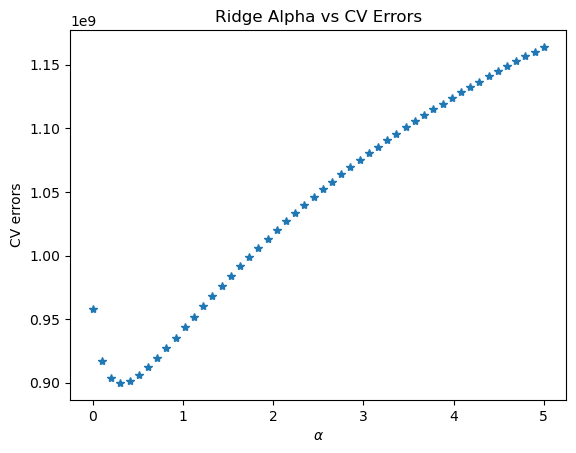

In [160]:
plt.plot(alphas_ridge, cv_errs_r, '*')
plt.title('Ridge Alpha vs CV Errors')
plt.xlabel(r'$\alpha$')
plt.ylabel('CV errors')

## Put coefficients into a table

In [161]:
coef_comp = pd.DataFrame({'var': vectorizer.get_feature_names_out(), 'var_ridge': ridgeReg.coef_})

coef_comp

,var,var_ridge
0,00,-3558.151875
1,000,27602.058052
2,0000,17.402536
3,00000754,120.185765
4,00a,-378.382623
...,...,...
12072,zoom,35.735065
12073,zpi,-139.713505
12074,zr,505.152290
12075,zulawski,-62.500153


## Focus on highest magnitude coefficients

In [163]:
coef_comp_sorted = coef_comp.reindex(coef_comp['var_ridge'].abs().sort_values(ascending=False).index)

#display top predictive words
top_predictive_words = coef_comp_sorted.head(25)
print(top_predictive_words)

                var     var_ridge
1111            and  34942.664524
1               000  27602.058052
877     advisortree  25646.176435
9894     settlement  19234.632326
12049           you  19078.421417
6867     management  19025.781729
954              ai  17078.131791
9952          shift -16359.918868
5947           info  15680.692006
1145      anthropic  15285.377074
6527           lead  14754.615668
9498           risk  14516.375279
5638           hour -13543.910505
3556        develop  13526.747383
7367           must -13073.772226
2697   compensation  13008.824596
3248       customer -12897.677279
2011       business  12824.403413
9314       research  12158.195567
1844           boss  12153.801624
7667             of  12092.344938
11794            we  11831.445640
11117       trading  11814.845501
6872       managing  11789.682603
4314         equity  11575.060667


### Top ten negative words

In [164]:
top_negative_words = coef_comp_sorted[coef_comp_sorted['var_ridge'] < 0].head(10)
top_negative_words


,var,var_ridge
9952,shift,-16359.918868
5638,hour,-13543.910505
7367,must,-13073.772226
3248,customer,-12897.677279
5346,guests,-10931.255592
3949,duties,-10929.621474
9302,required,-10511.365903
9876,service,-10131.617852
11816,week,-10062.748386
643,able,-9919.959307


### Top 20 positive words

In [166]:
top_positive_words = coef_comp_sorted[coef_comp_sorted['var_ridge'] > 0].head(20)
top_positive_words

,var,var_ridge
1111,and,34942.664524
1,000,27602.058052
877,advisortree,25646.176435
9894,settlement,19234.632326
12049,you,19078.421417
6867,management,19025.781729
954,ai,17078.131791
5947,info,15680.692006
1145,anthropic,15285.377074
6527,lead,14754.615668


# Let's do a Neural Network
Neural networks may be more effective for capturing complex relationships like our tfidf vector input variable and job salary target variable

In [178]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()


#define the neural net, with relu activation function and 64 layers, with input shape equal to number of features in our tfidf X:
model = Sequential()
model.add(Dense(64, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_data=(X_test_dense, y_test))
loss = model.evaluate(X_test_dense, y_test)


Epoch 1/10
16/16 [==============================] - 0s 7ms/step - loss: 7149220352.0000 - val_loss: 6220724736.0000
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 7149072384.0000 - val_loss: 6220518400.0000
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 7148784128.0000 - val_loss: 6220117504.0000
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 7148237824.0000 - val_loss: 6219411968.0000
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 7147311616.0000 - val_loss: 6218242560.0000
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 7145849344.0000 - val_loss: 6216468992.0000
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 7143630848.0000 - val_loss: 6213948928.0000
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 7140600320.0000 - val_loss: 6210416128.0000
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 

In [183]:
#Let's inspect the weights learned by our neural net:
weights = model.layers[0].get_weights()[0] #just the first layer's weights for now
feature_names = vectorizer.get_feature_names_out()
weights_df = pd.DataFrame(weights.T, columns=feature_names)
weights_df.head()
#seems like none of the weights are too strong

,00,000,0000,00000754,00a,00am,00p,00pm,01,010,...,zoladz,zone,zones,zoo,zoology,zoom,zpi,zr,zulawski,ámbitious
0,0.000222,-0.017276,-0.003108,-0.000310,0.003035,0.014242,0.021982,-0.021792,0.005225,-0.002031,...,0.005924,-0.015482,0.010595,-0.014703,-0.008793,-0.016011,0.012822,0.008451,-0.009268,-0.003879
1,0.248524,0.213638,0.070198,0.035549,0.064383,0.135860,0.058037,0.122634,0.085463,0.074145,...,0.056588,0.081490,0.080958,0.052740,0.072716,0.104175,0.038457,0.049132,0.059690,0.069585
2,0.200712,0.181163,0.085690,0.052171,0.063046,0.146851,0.040661,0.107361,0.109362,0.051483,...,0.039971,0.077908,0.116833,0.049912,0.084635,0.107394,0.043960,0.065577,0.054786,0.051560
3,0.204577,0.193506,0.041346,0.027816,0.035696,0.119518,0.032264,0.090041,0.069722,0.045596,...,0.033501,0.038067,0.065612,0.047877,0.031938,0.071969,0.041096,0.054183,0.031445,0.049114
4,0.243451,0.232848,0.085960,0.053931,0.072083,0.133703,0.062505,0.112931,0.095469,0.076311,...,0.073783,0.067889,0.117569,0.029527,0.078869,0.106414,0.052329,0.042125,0.073879,0.051437


## SHAP plot for feature importance: 
For our regression task, we want to see which input variables (i.e. which words) contribute most to our regression
We can visualize that using a shap plot: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html 

In [ ]:
import shap

explainer = shap.Explainer(model.predict, X_train_dense) #create shap explainer object using our predictions and training vals
shap_values = explainer(X_test_dense, max_evals=2 * X_test_dense.shape[1] + 1) #calculate SHAP values
shap.summary_plot(shap_values, X_test_dense, feature_names=vectorizer.get_feature_names_out()) #make a summaru plot
shap.plots.waterfall(shap_values[0], max_display=20) #individual shap values for specific instance
